## Library and Data Loading

In [12]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD, evaluate
%matplotlib inline

In [4]:
df_2 = pd.read_csv('combined_data_2.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
df_2['Rating'] = df_2['Rating'].astype(float)
print('Dataset 2 shape: {}'.format(df_2.shape))

Dataset 2 shape: (26982302, 2)


In [5]:
df_2.head(3)

,Cust_Id,Rating
0,4500:,NaN
1,2532865,4.0
2,573364,3.0


In [10]:
p = df_2.groupby('Rating')['Rating'].agg(['count'])

# get movie count
movie_count = df_2.isnull().sum()[1]

# get customer count
cust_count = df_2['Cust_Id'].nunique() - movie_count

# get rating count
rating_count = df_2['Cust_Id'].count() - movie_count

print('There are {} movies, {} customers, and {} rating records.'.format(movie_count, cust_count, rating_count))

There are 4711 movies, 474062 customers, and 26977591 rating records.


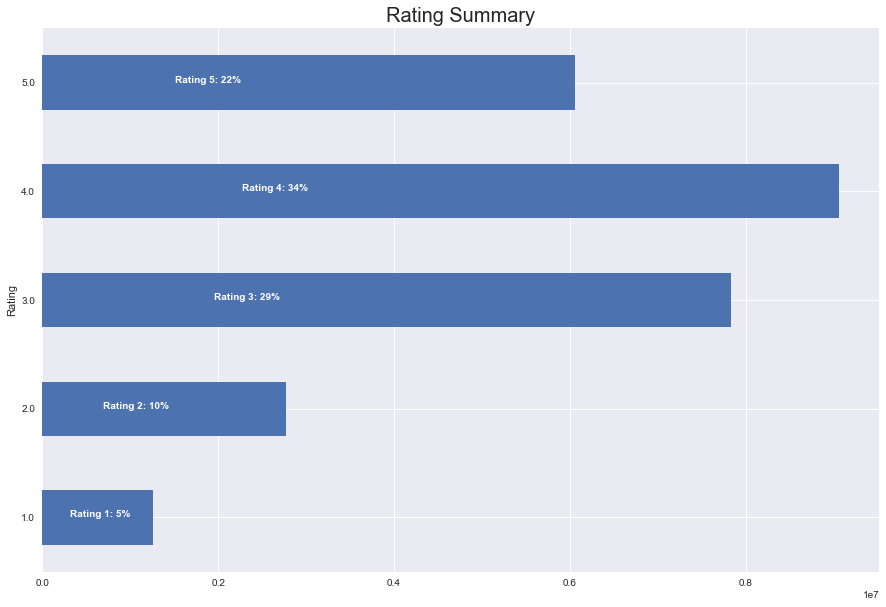

In [16]:
ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Rating Summary', fontsize=20)

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

## Data Processing

In [25]:
# Data cleaning
df_2_nan = pd.DataFrame(pd.isnull(df_2.Rating))
df_2_nan = df_2_nan[df_2_nan['Rating'] == True]
df_2_nan = df_2_nan.reset_index()
df_2_nan.head()

,index,Rating
0,0,True
1,259,True
2,855,True
3,960,True
4,2740,True


In [27]:
df_2.index = np.arange(0,len(df_2))
movie_np = []
movie_id = 1

for i,j in zip(df_2_nan['index'][1:],df_2_nan['index'][:-1]):
    # numpy approach
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1
    
last_record = np.full((1,len(df_2) - df_2_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))

Movie numpy: [  1.00000000e+00   1.00000000e+00   1.00000000e+00 ...,   4.71100000e+03
   4.71100000e+03   4.71100000e+03]
Length: 26977591


In [28]:
# remove those Movie ID rows
df_2 = df_2[pd.notnull(df_2['Rating'])]

df_2['Movie_Id'] = movie_np.astype(int)
df_2['Cust_Id'] = df_2['Cust_Id'].astype(int)
df_2.head()

,Cust_Id,Rating,Movie_Id
1,2532865,4.0,1
2,573364,3.0,1
3,1696725,3.0,1
4,1253431,3.0,1
5,1265574,2.0,1


In [29]:
# Data slicing:
f = ['count','mean']

df_2_movie_summary = df_2.groupby('Movie_Id')['Rating'].agg(f)
df_2_movie_summary.index = df_2_movie_summary.index.map(int)
movie_benchmark = round(df_2_movie_summary['count'].quantile(0.8),0)
drop_movie_list = df_2_movie_summary[df_2_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

df_2_cust_summary = df_2.groupby('Cust_Id')['Rating'].agg(f)
df_2_cust_summary.index = df_2_cust_summary.index.map(int)
cust_benchmark = round(df_2_cust_summary['count'].quantile(0.8),0)
drop_cust_list = df_2_cust_summary[df_2_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Movie minimum times of review: 4217.0
Customer minimum times of review: 88.0


In [30]:
print('Original Shape: {}'.format(df_2.shape))
df_2 = df_2[~df_2['Movie_Id'].isin(drop_movie_list)]
df_2 = df_2[~df_2['Cust_Id'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df_2.shape))

Original Shape: (26977591, 3)
After Trim Shape: (15107581, 3)


In [31]:
df_2.head()

,Cust_Id,Rating,Movie_Id
3158,716091,4.0,7
3159,1990901,4.0,7
3160,554875,4.0,7
3161,69867,3.0,7
3162,306466,5.0,7


In [32]:
n_users = df_2.Cust_Id.nunique()
n_movies = df_2.Movie_Id.nunique()
print('Num. of Users: '+ str(n_users))
print('Num of Movies: '+str(n_movies))
sparsity=round(1.0-len(df_2)/float(n_users*n_movies),3)
print('The sparsity level of Netflix Rating is ' +  str(sparsity*100) + '%')

Num. of Users: 94838
Num of Movies: 943
The sparsity level of Netflix Rating is 83.1%


In [33]:
df_2_p = pd.pivot_table(df_2,values='Rating',index='Cust_Id',columns='Movie_Id')
df_2_p.head()

Movie_Id,7,9,18,21,23,25,34,46,47,58,...,4647,4657,4661,4671,4676,4689,4690,4705,4706,4709
Cust_Id,,,,,,,,,,,,,,,,,,,,,
6,3.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4.0,3.0,3.0,NaN,NaN,5.0
7,NaN,NaN,NaN,4.0,NaN,NaN,NaN,5.0,4.0,5.0,...,NaN,5.0,NaN,NaN,NaN,NaN,4.0,3.0,4.0,NaN
79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,NaN,4.0,NaN,NaN,3.0,NaN,5.0,NaN,4.0
97,3.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
134,NaN,NaN,4.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,5.0,NaN


In [34]:
df_2_title = pd.read_csv("movie_titles.csv", encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
df_2_title.set_index('Movie_Id', inplace = True)
df_2_title.head()

,Year,Name
Movie_Id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


## SVD Recommander System

In [36]:
reader = Reader()

# get just top 100K rows for faster run time
data = Dataset.load_from_df(df_2[['Cust_Id', 'Movie_Id', 'Rating']][:100000], reader)
data.split(n_folds=3)

svd = SVD()
evaluate(svd, data, measures=['RMSE', 'MAE'])

/Users/ChuanShi/anaconda/lib/python3.6/site-packages/surprise/evaluate.py:66: UserWarning: The evaluate() method is deprecated. Please use model_selection.cross_validate() instead.
  'model_selection.cross_validate() instead.', UserWarning)
/Users/ChuanShi/anaconda/lib/python3.6/site-packages/surprise/dataset.py:193: UserWarning: Using data.split() or using load_from_folds() without using a CV iterator is now deprecated. 
  UserWarning)


Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 0.9854
MAE:  0.7746
------------
Fold 2
RMSE: 0.9844
MAE:  0.7742
------------
Fold 3
RMSE: 0.9935
MAE:  0.7876
------------
------------
Mean RMSE: 0.9878
Mean MAE : 0.7788
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'mae': [0.77455773849243004,
                             0.77420901480843296,
                             0.78764138962112595],
                            'rmse': [0.98541753202332028,
                             0.98437952125723971,
                             0.99351631817873831]})

In [38]:
df_716091 = df_2[(df_2['Cust_Id'] == 716091) & (df_2['Rating'] == 5)]
df_716091 = df_716091.set_index('Movie_Id')
df_716091 = df_716091.join(df_2_title)['Name']
df_716091.head()

Movie_Id
34     Ashtanga Yoga: Beginner's Practice with Nicki ...
58                                           Dragonheart
228                   Butch and Sundance: The Early Days
240                                    Woman of the Year
278                          100 Days Before the Command
Name: Name, dtype: object

In [41]:
user_716091 = df_2_title.copy()
user_716091 = user_716091.reset_index()
user_716091 = user_716091[~user_716091['Movie_Id'].isin(drop_movie_list)]

# getting full dataset
data = Dataset.load_from_df(df_2[['Cust_Id', 'Movie_Id', 'Rating']], reader)

trainset = data.build_full_trainset()
svd.train(trainset)

user_716091['Estimate_Score'] = user_716091['Movie_Id'].apply(lambda x: svd.predict(716091, x).est)

user_716091 = user_716091.drop('Movie_Id', axis = 1)

user_716091 = user_716091.sort_values('Estimate_Score', ascending=False)
user_716091.head(10)

/Users/ChuanShi/anaconda/lib/python3.6/site-packages/surprise/prediction_algorithms/algo_base.py:51: UserWarning: train() is deprecated. Use fit() instead
  warnings.warn('train() is deprecated. Use fit() instead', UserWarning)


,Year,Name,Estimate_Score
3659,1977.0,Iron Monkey,5.000000
1015,1976.0,The Killer Inside Me,5.000000
4332,1979.0,The BRD Trilogy: The Marriage of Maria Braun,4.858485
2737,1993.0,Born Yesterday,4.855785
2239,1997.0,Thrill Ride: The Science of Fun: IMAX,4.791845
1599,1995.0,Poison Ivy 2,4.780578
592,2000.0,Baby Genius: Mozart and Friends,4.678805
1038,1997.0,Lawn Dogs,4.644045
1945,2004.0,Spartacus,4.613764
227,1979.0,Butch and Sundance: The Early Days,4.608104
